In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_csv("/kaggle/input/app-store-apple-data-set-10k-apps/AppleStore.csv")

# Move the "user_rating" column to be the last column
cols = [col for col in df.columns if col != 'user_rating'] + ['user_rating']
df = df[cols]

df.describe()

/kaggle/input/app-store-apple-data-set-10k-apps/AppleStore.csv
/kaggle/input/app-store-apple-data-set-10k-apps/appleStore_description.csv


,Unnamed: 0,id,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating
count,7197.000000,7.197000e+03,7.197000e+03,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,4759.069612,8.631310e+08,1.991345e+08,1.726218,1.289291e+04,460.373906,3.253578,37.361817,3.707100,5.434903,0.993053,3.526956
std,3093.625213,2.712368e+08,3.592069e+08,5.833006,7.573941e+04,3920.455183,1.809363,3.737715,1.986005,7.919593,0.083066,1.517948
min,1.000000,2.816565e+08,5.898240e+05,0.000000,0.000000e+00,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,2090.000000,6.000937e+08,4.692275e+07,0.000000,2.800000e+01,1.000000,2.500000,37.000000,3.000000,1.000000,1.000000,3.500000
50%,4380.000000,9.781482e+08,9.715302e+07,0.000000,3.000000e+02,23.000000,4.000000,37.000000,5.000000,1.000000,1.000000,4.000000
75%,7223.000000,1.082310e+09,1.819249e+08,1.990000,2.793000e+03,140.000000,4.500000,38.000000,5.000000,8.000000,1.000000,4.500000
max,11097.000000,1.188376e+09,4.025970e+09,299.990000,2.974676e+06,177050.000000,5.000000,47.000000,5.000000,75.000000,1.000000,5.000000


# Explore the data
Let's try to find what data represents and find out the **correlation** between the features
This is needed to know where to start, how to **process** the **dataset** (Maybe drop duplicates, or maybe entire columns?), and what kind of **model** too choose in case we want to *predict* anything

In [2]:
df.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.5,6.3.5,4+,Games,38,5,10,1,4.0
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,3.5,8.2.2,4+,Productivity,37,5,23,1,4.0
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,4.5,5.0.0,4+,Weather,37,5,3,1,3.5
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.5,5.10.0,12+,Shopping,37,5,9,1,4.0
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,5.0,7.5.1,4+,Reference,37,5,45,1,4.5


Let's check if the `currency` column has anything other that USD in it.

In [3]:
currencies = df.drop_duplicates(subset=["currency"])
currencies

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.5,6.3.5,4+,Games,38,5,10,1,4.0


Interesting, so currency row is basically..useless? Wonderful, we'll get rid of it later on.
Now let's see if apps with no ratings provide any weight.

In [4]:
df.loc[df["rating_count_tot"] == 0]

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating
199,227,329174056,iLoan Calc (Loan calculator),3375104,USD,3.99,0,0,0.0,5.1.0,4+,Finance,37,5,3,1,0.0
301,340,350480010,eBook: War and Peace,8039424,USD,3.99,0,0,0.0,7.1,9+,Book,37,5,1,1,0.0
330,371,355709084,Jourist Weltübersetzer,147066880,USD,7.99,0,0,0.0,2.8,4+,Travel,40,5,1,1,0.0
441,503,377321278,恵方コンパス.,41207059,USD,0.00,0,0,0.0,2.1.0,4+,Navigation,39,5,1,1,0.0
452,517,379256460,「宅建士」過去問題《受験用》,24444928,USD,3.99,0,0,0.0,5.1,4+,Education,37,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,11038,1185428381,剑倚手游,178160640,USD,0.99,0,0,0.0,1.0,9+,Games,40,5,0,1,0.0
7182,11040,1185538497,camera for filter,9362432,USD,0.00,0,0,0.0,1.0.3,4+,Photo & Video,37,0,1,1,0.0
7184,11042,1185731859,剑客情缘-高爆率高掉落天天疯玩,171944960,USD,0.00,0,0,0.0,1.0,9+,Games,40,5,0,1,0.0
7185,11043,1185777521,问仙奇遇-新玩法新套装嗨到爆,208026624,USD,0.99,0,0,0.0,1.0,9+,Games,38,5,1,1,0.0


So...if an app doesn't have *any reviews,* then `user_rating` is always 0.0
Which, of course makes sense! This is not a surprise. However, what we do need to note is that if we're planning to build a model that predicts a given app's `user_rating`, (which we *are*) these **rows** should be treated as **outliers.**

# Let's see how different categories of apps perform on the market

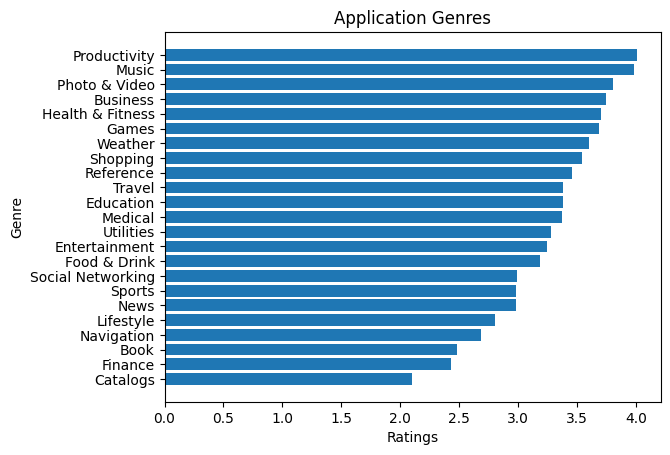

In [5]:
categories = df.groupby("prime_genre")["user_rating"].mean().sort_values()

plt.barh(categories.index, categories.values)
plt.title("Application Genres")
plt.xlabel("Ratings")
plt.ylabel("Genre")
plt.show()

# Correlation Matrix
For correlation matrix we'll have to get rid of the *App names* and any other `str` values that we do not need.
However, we should keep the **genres** column, because I am intrigued to see if it correlates with the `rating` column. For that we have to encode the column and make it an `int` column.
For that we'll use the `LabelEncoder`, provided by `sklearn`

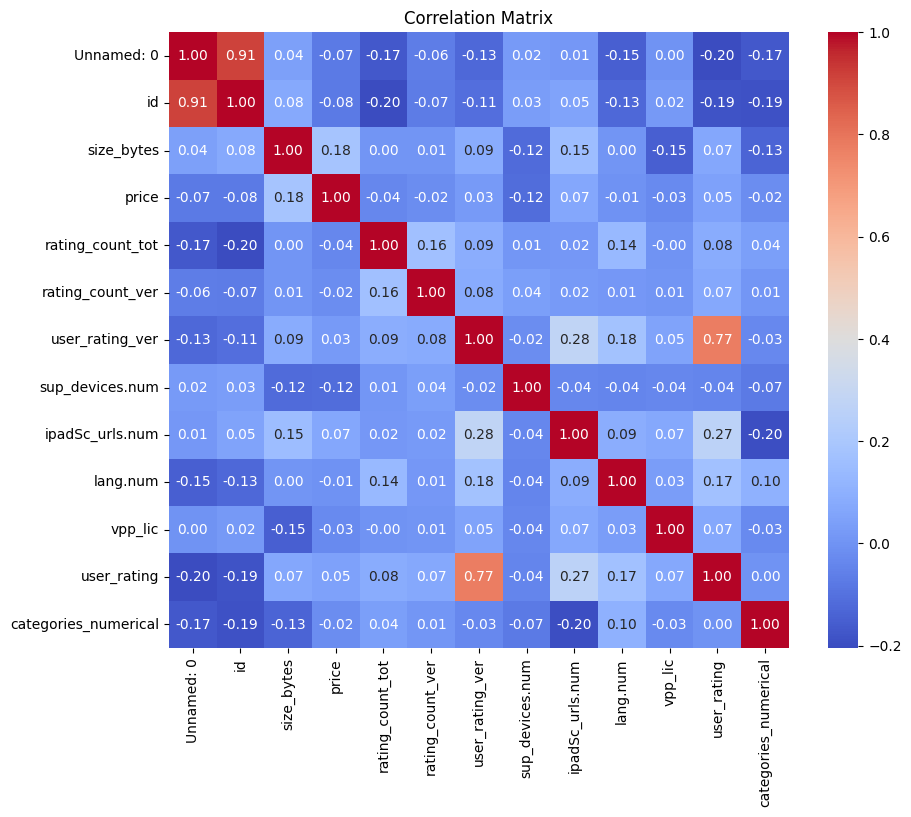

In [6]:
label_encoder = LabelEncoder()

# Convert "categories" column to numerical values
df['categories_numerical'] = label_encoder.fit_transform(df['prime_genre'])

# Filter out non-numerical columns
df_numeric = df.select_dtypes(include=[float, int])

correlation_matrix = df_numeric.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Results
Unfortunately, there aren't any columns that have a *strong* correlation with `user_rating`. (Well, besides `ipadSc_urls.num` which only scored `0.27`, and *number of supported languages* which only scored `0.17`)
<br>
Now let's try and make an model (We'll remove the **outliers** later, to see if it has any effect and if my statement before was correct)

In [7]:
def make_model(dataframe, Model):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values

    # Define model
    model = Model
    # Define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    # Force scores to be positive
    scores = np.absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

def evaluate_models(dataframe):
    print("Lasso Model results:")
    make_model(dataframe, Lasso(alpha=0.1))

    print("----------------------------------------")

    print("ElasticNet results:")
    make_model(dataframe, ElasticNet(random_state=0))
    
    print("----------------------------------------")

    print("Ensemble results:")
    make_model(dataframe, RandomForestRegressor(max_depth=2, random_state=42))

# evaluate_models(df_numeric)

# Model Result
> Lasso Model results: <br>
> Mean MAE: 3.287 (0.123) <br>
> ---------------------------------------- <br>
> ElasticNet results: <br>
> Mean MAE: 3.329 (0.128) <br>


First try proved to be an absolute fiasco! Now let's try to get a better score
<br>
(By the way, here's the score for `Lasso` with `alpha=1`):
> Mean MAE: 3.380 (0.130)

In [8]:
df = df_numeric.drop(df_numeric[df_numeric["rating_count_tot"] == 0].index)

df.describe()
evaluate_models(df)

Lasso Model results:
Mean MAE: 3.253 (0.128)
----------------------------------------
ElasticNet results:
Mean MAE: 3.313 (0.125)
----------------------------------------
Ensemble results:
Mean MAE: 3.200 (0.126)
